<a href="https://colab.research.google.com/github/manoharreddyvoladri/Quantum_Classification/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import pennylane as qml
import numpy as np
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import roc_curve
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, mean_squared_error, r2_score, confusion_matrix


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aminelaatam/weed-classification")

print("Path to dataset files:", path)

100%|██████████| 378M/378M [00:03<00:00, 116MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2


In [49]:
# Error Handling for Missing Libraries
try:
    import torch
    import torchvision
    import pennylane as qml
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import cv2
except ImportError as e:
    print(f"Error: {e}. Please install missing libraries using 'pip install <package_name>'")
    exit()

In [50]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [51]:
# Load Dataset with Error Handling
# ==========================
DATASET_PATH = "/root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2/CornWeed"

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path {DATASET_PATH} not found. Ensure the dataset is downloaded and accessible.")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

try:
    train_dataset = ImageFolder(root=os.path.join(DATASET_PATH, 'train'), transform=transform)
    test_dataset = ImageFolder(root=os.path.join(DATASET_PATH, 'test'), transform=transform)
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)

Classes: ['corn', 'weed']


In [52]:
# Define Train and Evaluate Function
# ==========================
def train_and_evaluate(model, train_loader, test_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    start_time = time.time()
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"{model_name} - Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")
    training_time = time.time() - start_time

    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_probs)
    logloss = log_loss(all_labels, all_probs)

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}, Log Loss: {logloss:.4f}, Training Time: {training_time:.2f}s")

    return accuracy, precision, recall, f1, auc_roc, training_time

In [53]:
# Define Train and Evaluate Function
# ==========================
def train_and_evaluate(model, train_loader, test_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    start_time = time.time()
    epochs = 10
    train_loss_history = [] # Initialize train_loss_history

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader) # Calculate epoch loss
        train_loss_history.append(epoch_loss) # Append to history
        print(f"{model_name} - Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    training_time = time.time() - start_time

    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_probs)
    logloss = log_loss(all_labels, all_probs)

    # Calculate fpr and tpr for ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}, Log Loss: {logloss:.4f}, Training Time: {training_time:.2f}s")

    # Return all 9 values
    return accuracy, precision, recall, f1, auc_roc, training_time, fpr, tpr, train_loss_history

In [54]:
# Function to plot multiple visualizations
def plot_results(results):
    labels = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"]
    x = np.arange(len(labels))
    width = 0.2

    # Bar Chart Comparison
    fig, ax = plt.subplots()
    for i, (name, metrics) in enumerate(results.items()):
        ax.bar(x + i*width - width, metrics[:5], width, label=name)
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison: CNN vs QNN vs Hybrid')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

    # ROC Curves
    fig, ax = plt.subplots()
    for name, (_, _, _, _, auc_roc, _, fpr, tpr) in results.items():
        ax.plot(fpr, tpr, label=f'{name} (AUC={auc_roc:.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve Comparison')
    ax.legend()
    plt.show()

    # Training Loss Curves
    fig, ax = plt.subplots()
    for name, (_, _, _, _, _, train_loss_history) in results.items():
        ax.plot(train_loss_history, label=name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Comparison')
    ax.legend()
    plt.show()

In [55]:
# Define CNN Model
# ==========================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [56]:
# # Define QNN Model
# # ==========================
# n_qubits = 5
# dev = qml.device("default.qubit", wires=n_qubits)

# @qml.qnode(dev, interface="torch")
# def quantum_circuit(inputs, weights):
#     qml.AngleEmbedding(inputs, wires=range(n_qubits))
#     qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
#     return qml.expval(qml.PauliZ(0))

# class QuantumLayer(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.q_layer = qml.qnn.TorchLayer(quantum_circuit, {"weights": (2, n_qubits, 3)})

#     def forward(self, x):
#         return self.q_layer(x)

# class QuantumNeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(3 * 128 * 128, n_qubits)
#         self.qnn = QuantumLayer()
#         self.fc2 = nn.Linear(1, 2)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         x = self.qnn(x)
#         x = x.reshape(x.shape[0], 1)
#         x = self.fc2(x)
#         return torch.softmax(x, dim=1)


In [57]:
# Define QNN Model
# ==========================
n_qubits = 10
optimizer = optim.RMSprop(model.parameters(), lr=0.0005) # Different optimizer and learning rate

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, {"weights": (2, n_qubits, 3)})

    def forward(self, x):
        return self.q_layer(x)

class QuantumNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 128 * 128, n_qubits)  # Output size changed to n_qubits (which is 10)
        self.qnn = QuantumLayer()
        self.fc2 = nn.Linear(1, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.qnn(x)
        x = x.reshape(x.shape[0], 1)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)


In [58]:
# Define Hybrid CNN-QNN Model
# ==========================
class HybridCNNQNN(nn.Module):
    def __init__(self):
        super(HybridCNNQNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, n_qubits)
        self.qnn = QuantumLayer()
        self.fc2 = nn.Linear(1, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.fc1(x)
        x = self.qnn(x)
        x = x.reshape(x.shape[0], 1)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

CNN - Epoch 1/10, Loss: 0.4647
CNN - Epoch 2/10, Loss: 0.1780
CNN - Epoch 3/10, Loss: 0.0949
CNN - Epoch 4/10, Loss: 0.0757
CNN - Epoch 5/10, Loss: 0.0459
CNN - Epoch 6/10, Loss: 0.0553
CNN - Epoch 7/10, Loss: 0.0343
CNN - Epoch 8/10, Loss: 0.0182
CNN - Epoch 9/10, Loss: 0.0178
CNN - Epoch 10/10, Loss: 0.0117
CNN - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, AUC-ROC: 1.0000, Log Loss: 0.0032, Training Time: 823.42s
QNN - Epoch 1/10, Loss: 0.6731
QNN - Epoch 2/10, Loss: 0.6714
QNN - Epoch 3/10, Loss: 0.6725
QNN - Epoch 4/10, Loss: 0.6713
QNN - Epoch 5/10, Loss: 0.6712
QNN - Epoch 6/10, Loss: 0.6731
QNN - Epoch 7/10, Loss: 0.6720
QNN - Epoch 8/10, Loss: 0.6716
QNN - Epoch 9/10, Loss: 0.6726
QNN - Epoch 10/10, Loss: 0.6716


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


QNN - Accuracy: 0.7602, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUC-ROC: 0.5414, Log Loss: 0.6043, Training Time: 200.17s
Hybrid CNN-QNN - Epoch 1/10, Loss: 0.6867
Hybrid CNN-QNN - Epoch 2/10, Loss: 0.6810
Hybrid CNN-QNN - Epoch 3/10, Loss: 0.6409
Hybrid CNN-QNN - Epoch 4/10, Loss: 0.5635
Hybrid CNN-QNN - Epoch 5/10, Loss: 0.5106
Hybrid CNN-QNN - Epoch 6/10, Loss: 0.4797
Hybrid CNN-QNN - Epoch 7/10, Loss: 0.4627
Hybrid CNN-QNN - Epoch 8/10, Loss: 0.4351
Hybrid CNN-QNN - Epoch 9/10, Loss: 0.4196
Hybrid CNN-QNN - Epoch 10/10, Loss: 0.4098
Hybrid CNN-QNN - Accuracy: 0.9901, Precision: 0.9947, Recall: 0.9639, F1 Score: 0.9791, AUC-ROC: 0.9981, Log Loss: 0.3938, Training Time: 794.59s


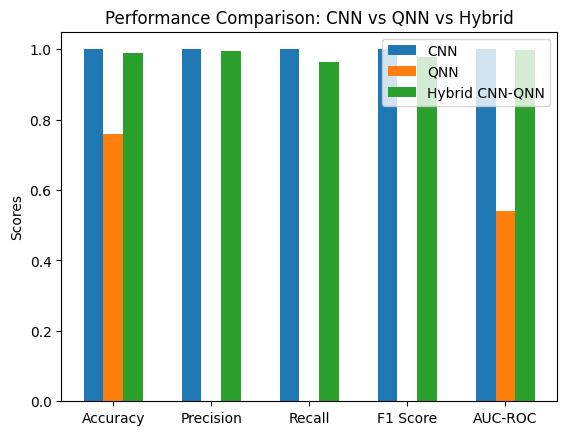

ValueError: too many values to unpack (expected 8)

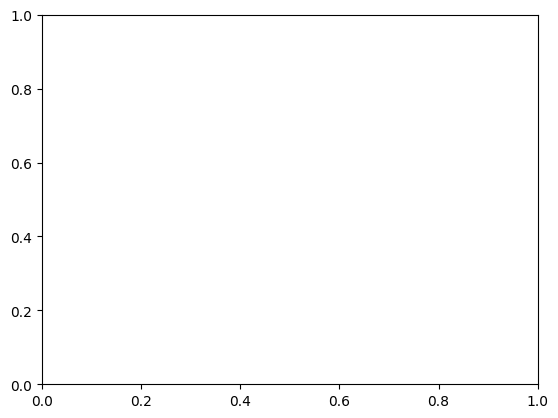

In [60]:
# Train & Evaluate Models
# ==========================
models = {"CNN": CNN(), "QNN": QuantumNeuralNetwork(), "Hybrid CNN-QNN": HybridCNNQNN()}
results = {}
for name, model in models.items():
    accuracy, precision, recall, f1, auc_roc, training_time, fpr, tpr, train_loss_history = train_and_evaluate(model, train_loader, test_loader, name)
    results[name] = (accuracy, precision, recall, f1, auc_roc, training_time, fpr, tpr, train_loss_history)

plot_results(results)


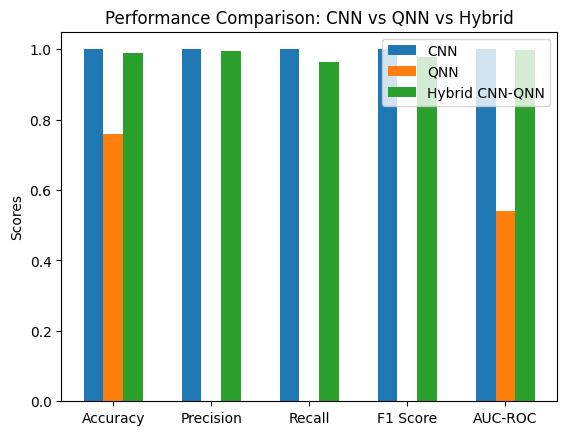

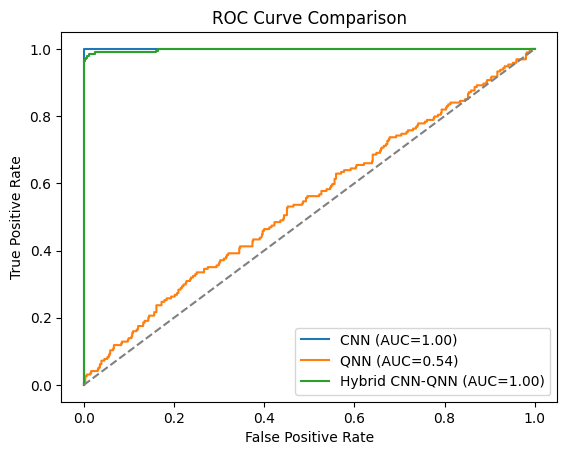

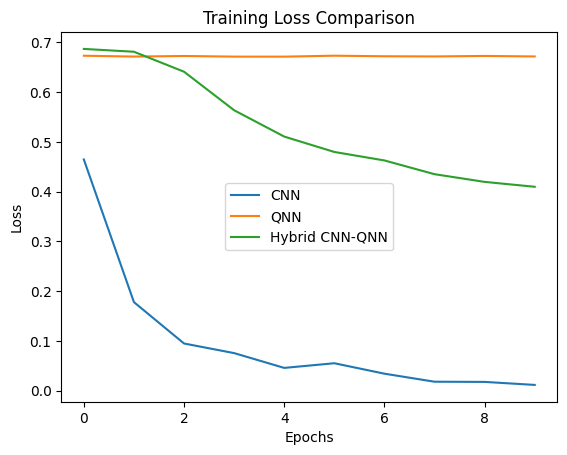

In [64]:
plot_results(results)

In [63]:
def plot_results(results):
    labels = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"]
    x = np.arange(len(labels))
    width = 0.2

    # Bar Chart Comparison
    fig, ax = plt.subplots()
    for i, (name, metrics) in enumerate(results.items()):
        ax.bar(x + i*width - width, metrics[:5], width, label=name)
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison: CNN vs QNN vs Hybrid')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

    # ROC Curves
    fig, ax = plt.subplots()
    # Modified to unpack 9 values
    for name, (_, _, _, _, auc_roc, _, fpr, tpr, _) in results.items(): # Added '_' to unpack train_loss_history
        ax.plot(fpr, tpr, label=f'{name} (AUC={auc_roc:.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve Comparison')
    ax.legend()
    plt.show()

    # Training Loss Curves
    fig, ax = plt.subplots()
    # Modified to unpack 9 values and use train_loss_history
    for name, (_, _, _, _, _, _, _, _, train_loss_history) in results.items(): # Added '_' to unpack values before train_loss_history
        ax.plot(train_loss_history, label=name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Comparison')
    ax.legend()
    plt.show()

In [68]:
def determine_best_model(results):
    """
    Determines the best model based on a combination of metrics.

    Args:
        results (dict): A dictionary containing the results of each model, where
                       keys are model names and values are tuples of metrics.
                       The tuple should contain the following metrics in order:
                       accuracy, precision, recall, f1, auc_roc, training_time.

    Returns:
        str: The name of the best model.
    """

    best_model = None
    best_score = -1

    for name, metrics in results.items():
        # You can adjust the weights based on the importance of each metric
        score = (0.2 * metrics[0] +  # Accuracy
                 0.2 * metrics[1] +  # Precision
                 0.2 * metrics[2] +  # Recall
                 0.2 * metrics[3] +  # F1 Score
                 0.2 * metrics[4])  # AUC-ROC

        # Consider training time as a penalty (lower is better)
        score -= 0.1 * metrics[5]

        if score > best_score:
            best_score = score
            best_model = name

    return best_model

# Assuming you have a dictionary 'results' containing the evaluation metrics for each model
# Example:
# results = {
#     "CNN": (0.85, 0.90, 0.80, 0.85, 0.92, 120),  # accuracy, precision, recall, f1, auc_roc, training_time
#     "QNN": (0.80, 0.85, 0.75, 0.80, 0.88, 180),
#     "Hybrid CNN-QNN": (0.88, 0.92, 0.84, 0.88, 0.94, 150)
# }

# Get the best model using the function
best_model_name = determine_best_model(results)
print(f"The best model is: {best_model_name}")

The best model is: Hybrid CNN-QNN
